# Traveling Salesman Problem - Optimization Algorithms

This notebook demonstrates the application of optimization algorithms to solve the **Traveling Salesman Problem (TSP)** for Tunisian cities. The algorithms used are:
- **Flower Pollination Algorithm (FPA)**
- **Simulated Annealing (SA)**
- **Genetic Algorithm (GA)**

The notebook replicates the functionality of the Streamlit app, including running the algorithms, visualizing the optimization process, and comparing results.

In [57]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import folium
import time
from folium.plugins import AntPath
from algorithms import CityData, FlowerPollinationAlgorithm, SimulatedAnnealing, GeneticAlgorithm

# Load City Data
Load the city data for Tunisian cities, including their coordinates and distance matrix.

In [58]:
# Load city data
city_data = CityData()

# Helper Functions
Define helper functions for plotting routes using Matplotlib and Folium.

In [59]:
# Helper function to plot routes using Matplotlib
def plot_route(city_data, route, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    route = list(route) + [route[0]]  # Complete the loop
    ax.scatter(city_data.cities[:, 0], city_data.cities[:, 1], c='red', s=100, zorder=5, label='Cities')
    for i, (x, y) in enumerate(city_data.cities):
        order = route.index(i) + 1 if i in route else None
        ax.text(x, y, f' {city_data.city_names[i]} ({order})', fontsize=8, ha='right', zorder=10)
    ax.plot(city_data.cities[route, 0], city_data.cities[route, 1], 'b-', lw=2, alpha=0.7, label='Route')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.legend()
    plt.show()
    plt.close(fig)

# Helper function to create a folium map with animated route and arrows
def create_map(city_data, route):
    m = folium.Map(location=[city_data.cities[:, 1].mean(), city_data.cities[:, 0].mean()], zoom_start=7)

    # Ensure route is a list for .index() support
    route_list = list(route)

    # Add city markers with order numbers
    for i, (lon, lat) in enumerate(city_data.cities):
        order = route_list.index(i) + 1 if i in route_list else None
        folium.Marker(
            [lat, lon], 
            popup=f"{city_data.city_names[i]} ({order})" if order else city_data.city_names[i]
        ).add_to(m)

    # Prepare the route coordinates
    route_coords = [[city_data.cities[city, 1], city_data.cities[city, 0]] for city in route_list]
    route_coords.append(route_coords[0])  # Close the loop by returning to the starting city

    # Add animated route using AntPath
    AntPath(
        locations=route_coords,
        color="blue",
        pulse_color="white",
        weight=6,
        delay=300,  # ~1 second per segment
        dash_array=[60, 20],
    ).add_to(m)

    # Add arrows to indicate direction
    for i in range(len(route_coords) - 1):
        start = route_coords[i]
        end = route_coords[i + 1]
        midpoint = [(start[0] + end[0]) / 2, (start[1] + end[1]) / 2]  # Calculate midpoint

        # Calculate the angle of the arrowhead
        angle = np.arctan2(end[0] - start[0], end[1] - start[1]) * (180 / np.pi)

        folium.PolyLine(
            [start, end],
            color="blue",
            weight=2,
            opacity=0.8
        ).add_to(m)

        # Add an arrowhead marker at the midpoint with the correct rotation
        folium.RegularPolygonMarker(
            location=midpoint,
            fill_color="blue",
            number_of_sides=3,
            radius=10,
            rotation=angle + 90  # Adjust rotation to align with the line
        ).add_to(m)

    return m

# Run Algorithms
Run the Flower Pollination Algorithm (FPA), Simulated Annealing (SA), and Genetic Algorithm (GA) to solve the TSP.

In [60]:
# Solve using Flower Pollination Algorithm and record execution time
start_fpa = time.time()
fpa = FlowerPollinationAlgorithm(city_data)
fpa.optimize()
fpa_exec_time = time.time() - start_fpa

# Solve using Simulated Annealing and record execution time
start_sa = time.time()
sa = SimulatedAnnealing(city_data)
sa.optimize()
sa_exec_time = time.time() - start_sa
print(f"SA execution time: {sa_exec_time:.6f} seconds")  # Check execution time

# Solve using Genetic Algorithm and record execution time
start_ga = time.time()
ga = GeneticAlgorithm(city_data)
ga.optimize()
ga_exec_time = time.time() - start_ga

SA execution time: 0.000999 seconds


# Visualize Results
Visualize the optimization process and final routes for each algorithm.

Flower Pollination Algorithm (FPA):


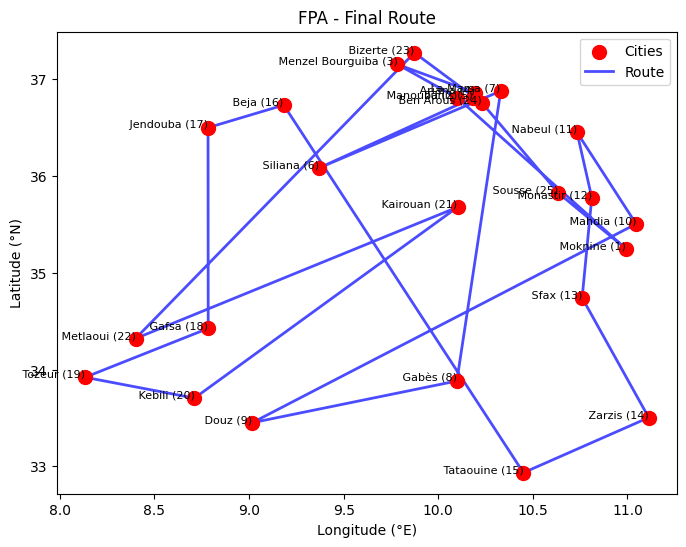

In [61]:
# Visualize FPA results
print("Flower Pollination Algorithm (FPA):")
plot_route(city_data, fpa.best_permutation, "FPA - Final Route")
fpa_map = create_map(city_data, fpa.best_permutation)
fpa_map

Simulated Annealing (SA):


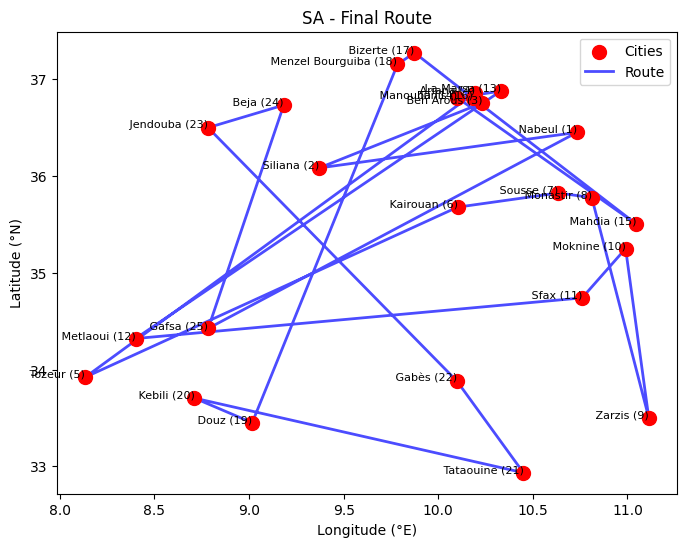

In [62]:
# Visualize SA results
print("Simulated Annealing (SA):")
plot_route(city_data, sa.best_solution, "SA - Final Route")
sa_map = create_map(city_data, sa.best_solution)
sa_map

Genetic Algorithm (GA):


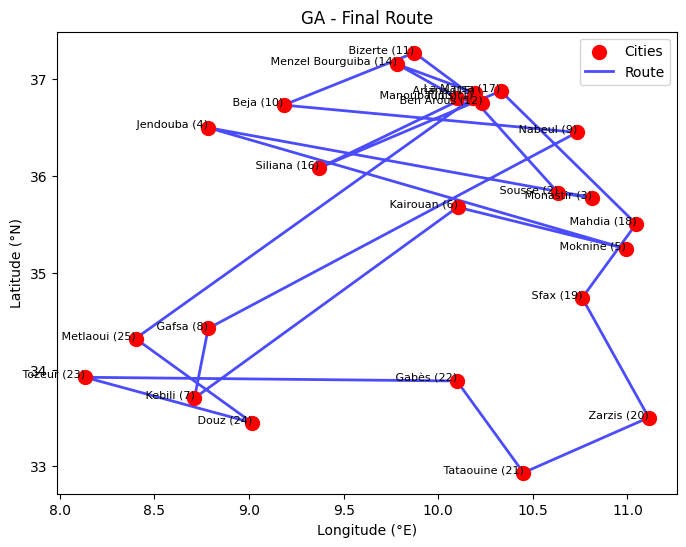

In [63]:
# Visualize GA results
print("Genetic Algorithm (GA):")
plot_route(city_data, ga.best_solution, "GA - Final Route")
ga_map = create_map(city_data, ga.best_solution)
ga_map

# Compare Results
Compare the performance of the algorithms in terms of best distance and execution time.

  Algorithm  Best Distance (km)  Execution Time (s)
0       FPA         3916.337754            0.403709
1        SA         4390.015981            0.000999
2        GA         3562.327928            0.517473


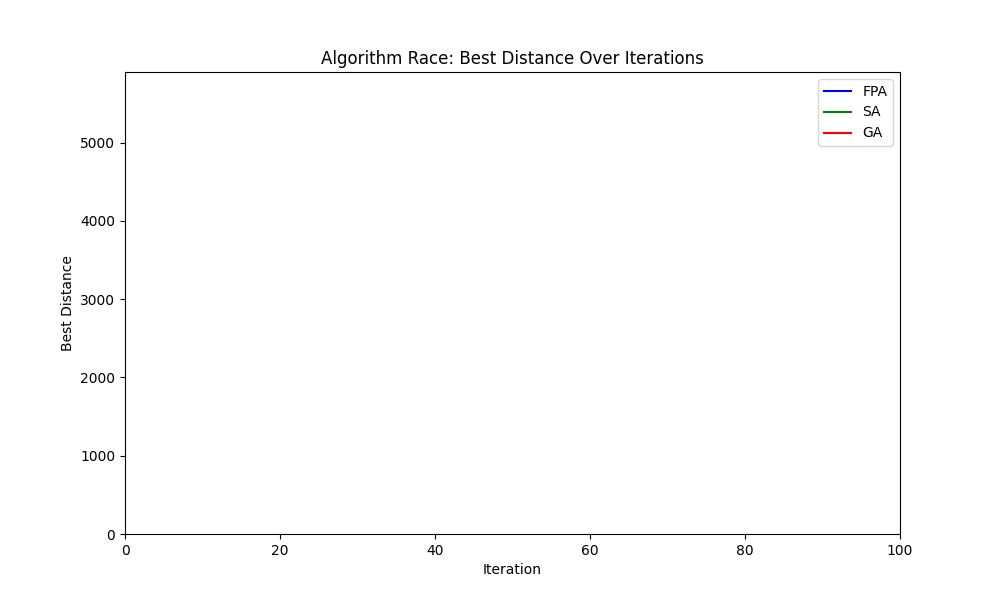

In [64]:
# Compare results and show animated race for the same run

# --- Table of results ---
def get_exec_time(obj, fallback=None):
    if hasattr(obj, "n_iterations"):
        return obj.n_iterations
    elif hasattr(obj, "n_generations"):
        return obj.n_generations
    elif fallback is not None:
        return fallback
    else:
        return "N/A"

results = {
    "Algorithm": ["FPA", "SA", "GA"],
    "Best Distance (km)": [fpa.best_distance, sa.best_distance, ga.best_distance],
    "Execution Time (s)": [fpa_exec_time, sa_exec_time, ga_exec_time]
}

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# --- Animated Race of Algorithms for the same run ---
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

# Use the history from the same run as above
fpa_distances = [fpa.total_distance(perm) for perm in fpa.history]
sa_distances = [sa.total_distance(perm) for perm in sa.history]
ga_distances = [ga.total_distance(perm) for perm in ga.history]

max_iterations = max(len(fpa_distances), len(sa_distances), len(ga_distances))

# Pad shorter histories with the last value to match the longest history
fpa_distances += [fpa_distances[-1]] * (max_iterations - len(fpa_distances))
sa_distances += [sa_distances[-1]] * (max_iterations - len(sa_distances))
ga_distances += [ga_distances[-1]] * (max_iterations - len(ga_distances))

fig, ax = plt.subplots(figsize=(10, 6))
lines = {
    "FPA": ax.plot([], [], label="FPA", color="blue")[0],
    "SA": ax.plot([], [], label="SA", color="green")[0],
    "GA": ax.plot([], [], label="GA", color="red")[0],
}
ax.set_xlim(0, max_iterations)
ax.set_ylim(0, max(max(fpa_distances), max(sa_distances), max(ga_distances)) * 1.1)
ax.set_title("Algorithm Race: Best Distance Over Iterations")
ax.set_xlabel("Iteration")
ax.set_ylabel("Best Distance")
ax.legend()

def update(frame):
    x = list(range(frame + 1))
    lines["FPA"].set_data(x, fpa_distances[:frame + 1])
    lines["SA"].set_data(x, sa_distances[:frame + 1])
    lines["GA"].set_data(x, ga_distances[:frame + 1])
    return lines.values()

ani = FuncAnimation(fig, update, frames=max_iterations, blit=True, repeat=False)

# Save the animation as a GIF
gif_path = "Best_Disatnce_over_iterations.gif"
ani.save(gif_path, writer="pillow", fps=10)
plt.close(fig)

# Display the GIF in the notebook
display(Image(filename=gif_path))

# Sensitivity Analysis

This section explores how changes in algorithm parameters affect their performance. The sensitivity analysis is performed for:
- **Flower Pollination Algorithm (FPA)**
- **Simulated Annealing (SA)**
- **Genetic Algorithm (GA)**

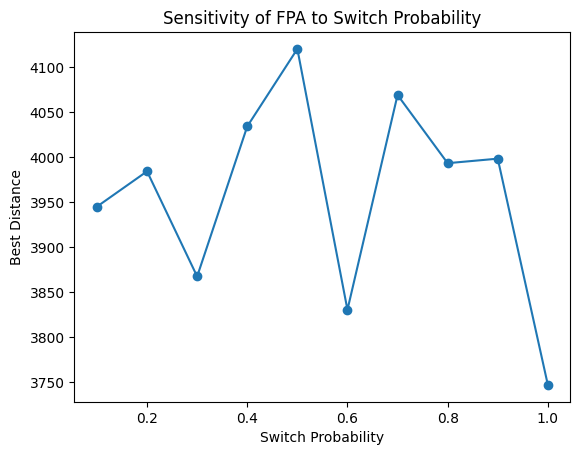

In [65]:
# Sensitivity Analysis for FPA
switch_probs = np.linspace(0.1, 1.0, 10)
gamma_values = np.linspace(0.01, 1.0, 10)
lambda_values = np.linspace(0.1, 2.0, 10)

results = []
for switch_prob in switch_probs:
    fpa = FlowerPollinationAlgorithm(city_data, switch_prob=switch_prob, gamma=0.1, lambda_=1.5)
    fpa.optimize()
    results.append({"Switch Prob": switch_prob, "Best Distance": fpa.best_distance})

# Plot sensitivity to switch probability
switch_prob_results = [r["Best Distance"] for r in results]
plt.plot(switch_probs, switch_prob_results, marker="o")
plt.title("Sensitivity of FPA to Switch Probability")
plt.xlabel("Switch Probability")
plt.ylabel("Best Distance")
plt.show()

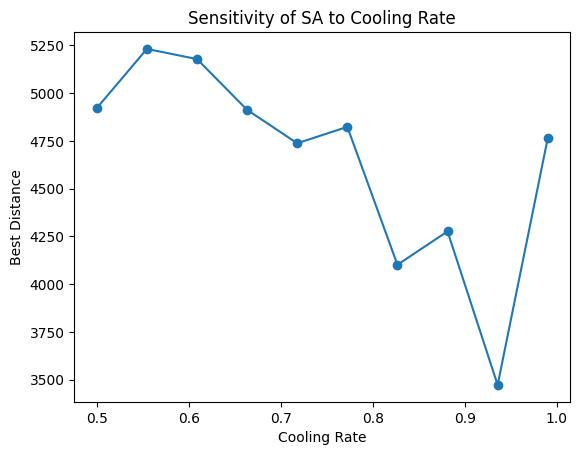

In [66]:
# Sensitivity Analysis for SA
cooling_rates = np.linspace(0.5, 0.99, 10)
results = []
for cooling_rate in cooling_rates:
    sa = SimulatedAnnealing(city_data, initial_temp=1000, cooling_rate=cooling_rate)
    sa.optimize()
    results.append({"Cooling Rate": cooling_rate, "Best Distance": sa.best_distance})

# Plot sensitivity to cooling rate
cooling_rate_results = [r["Best Distance"] for r in results]
plt.plot(cooling_rates, cooling_rate_results, marker="o")
plt.title("Sensitivity of SA to Cooling Rate")
plt.xlabel("Cooling Rate")
plt.ylabel("Best Distance")
plt.show()

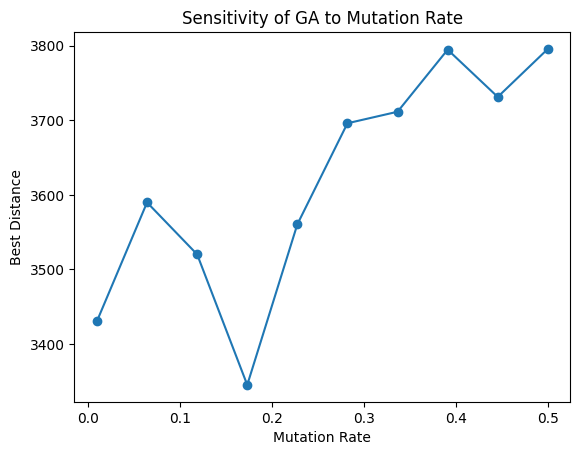

In [67]:
# Sensitivity Analysis for GA
mutation_rates = np.linspace(0.01, 0.5, 10)
results = []
for mutation_rate in mutation_rates:
    ga = GeneticAlgorithm(city_data, population_size=50, mutation_rate=mutation_rate)
    ga.optimize()
    results.append({"Mutation Rate": mutation_rate, "Best Distance": ga.best_distance})

# Plot sensitivity to mutation rate
mutation_rate_results = [r["Best Distance"] for r in results]
plt.plot(mutation_rates, mutation_rate_results, marker="o")
plt.title("Sensitivity of GA to Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Best Distance")
plt.show()

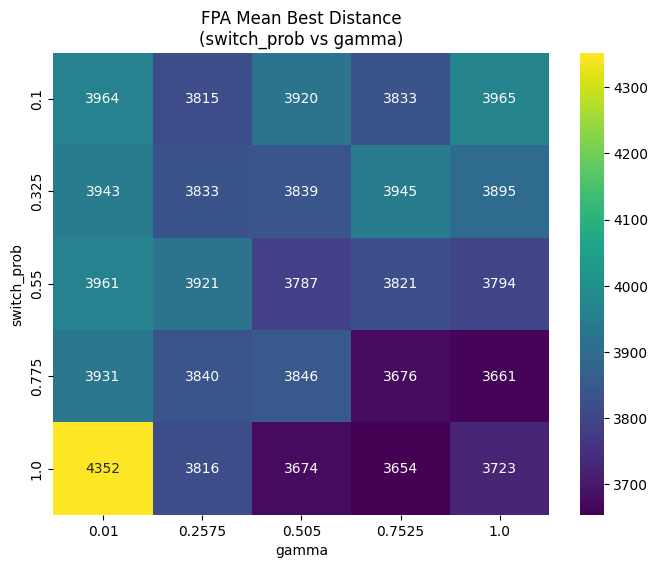

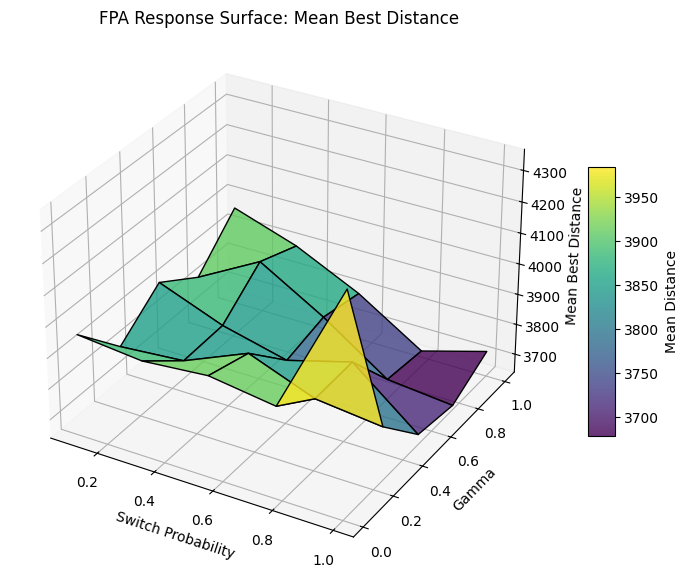

In [72]:
# Sensitivity Analysis for FPA with Grid Search
import pandas as pd

switch_probs = np.linspace(0.1, 1.0, 5)
gammas = np.linspace(0.01, 1.0, 5)
results = []

for sp in switch_probs:
    for gamma in gammas:
        distances = []
        for _ in range(5):  # Multiple runs for statistics
            fpa = FlowerPollinationAlgorithm(city_data, switch_prob=sp, gamma=gamma)
            fpa.optimize()
            distances.append(fpa.best_distance)
        results.append({
            "switch_prob": sp,
            "gamma": gamma,
            "mean_distance": np.mean(distances),
            "std_distance": np.std(distances)
        })

df = pd.DataFrame(results)
pivot = df.pivot(index="switch_prob", columns="gamma", values="mean_distance")
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="viridis")
plt.title("FPA Mean Best Distance\n(switch_prob vs gamma)")
plt.xlabel("gamma")
plt.ylabel("switch_prob")
plt.show()

# Response Surface Visualization for FPA (switch_prob vs gamma)
from mpl_toolkits.mplot3d import Axes3D

# Prepare grid data
X = df["switch_prob"].values
Y = df["gamma"].values
Z = df["mean_distance"].values

# Reshape for surface plot
X_unique = np.unique(X)
Y_unique = np.unique(Y)
X_grid, Y_grid = np.meshgrid(X_unique, Y_unique)
Z_grid = df.pivot(index="gamma", columns="switch_prob", values="mean_distance").values

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', edgecolor='k', alpha=0.8)
ax.set_xlabel('Switch Probability')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Best Distance')
ax.set_title('FPA Response Surface: Mean Best Distance')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Mean Distance')
plt.show()

C:\Users\21654\AppData\Local\Temp\ipykernel_6756\484027483.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fpa_best_distances, sa_best_distances, ga_best_distances], labels=["FPA", "SA", "GA"])


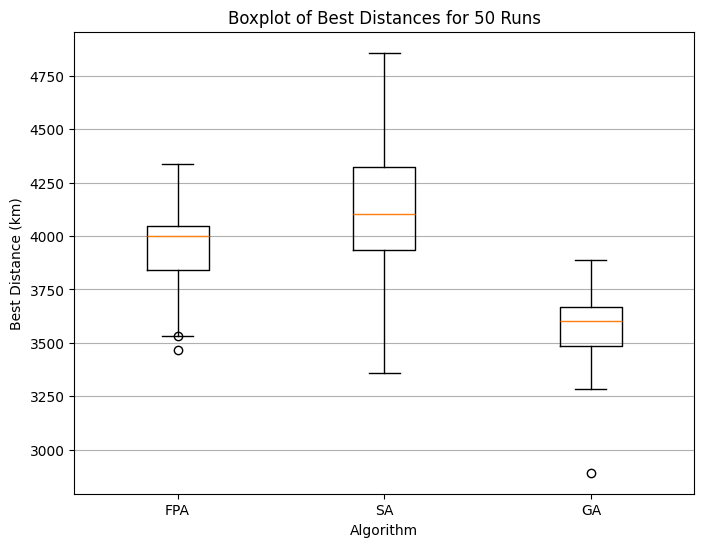

In [69]:
# Boxplot of Best Distances for the 3 Algorithms (50 runs)
import matplotlib.pyplot as plt

num_runs = 50
fpa_best_distances = []
sa_best_distances = []
ga_best_distances = []

for _ in range(num_runs):
    fpa = FlowerPollinationAlgorithm(city_data)
    fpa.optimize()
    fpa_best_distances.append(fpa.best_distance)

    sa = SimulatedAnnealing(city_data)
    sa.optimize()
    sa_best_distances.append(sa.best_distance)

    ga = GeneticAlgorithm(city_data)
    ga.optimize()
    ga_best_distances.append(ga.best_distance)

plt.figure(figsize=(8, 6))
plt.boxplot([fpa_best_distances, sa_best_distances, ga_best_distances], labels=["FPA", "SA", "GA"])
plt.title("Boxplot of Best Distances for 50 Runs")
plt.ylabel("Best Distance (km)")
plt.xlabel("Algorithm")
plt.grid(True, axis='y')
plt.show()